# Universidad del Valle de Guatemala
## Security Data Science - 10
* Walter Danilo Saldaña Salguero - 19897
* Javier Alejandro Cotto Argueta - 19324

## Laboratorio 6: Clasificación de Malware con DL

Importamos librearias

In [1]:
import os, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

2023-04-30 20:19:13.115149: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 20:19:13.494519: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 20:19:13.498342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 20:19:14.601933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Creamos el Dataset

In [2]:
from tabulate import tabulate

path = './malimg_paper_dataset_imgs/'

family_quantity = 0
ids = 0
columns = ['id', 'familyId', 'familyName', 'file', 'path', 'height', 'width']
data = []
for folder in os.listdir(path):
    if ('.txt' in folder): continue
    cont = 0
    full_path = path + folder + '/'
    for file in os.listdir(full_path):
        full_file_path = full_path + file
        img = cv2.imread(full_file_path, cv2.IMREAD_UNCHANGED)
        height, width = img.shape
        data.append([id, family_quantity, folder, file, full_file_path, height, width])
        cont += 1
        ids += 1
    print("Los ejemplares de la familia ", family_quantity, folder, " son\n", cont)
    family_quantity += 1
data = pd.DataFrame(data=data, columns=columns)

Los ejemplares de la familia  0 Adialer.C  son
 122
Los ejemplares de la familia  1 Agent.FYI  son
 116
Los ejemplares de la familia  2 Allaple.A  son
 2949
Los ejemplares de la familia  3 Allaple.L  son
 1591
Los ejemplares de la familia  4 Alueron.gen!J  son
 198
Los ejemplares de la familia  5 Autorun.K  son
 106
Los ejemplares de la familia  6 C2LOP.gen!g  son
 200
Los ejemplares de la familia  7 C2LOP.P  son
 146
Los ejemplares de la familia  8 Dialplatform.B  son
 177
Los ejemplares de la familia  9 Dontovo.A  son
 162
Los ejemplares de la familia  10 Fakerean  son
 381
Los ejemplares de la familia  11 Instantaccess  son
 431
Los ejemplares de la familia  12 Lolyda.AA1  son
 213
Los ejemplares de la familia  13 Lolyda.AA2  son
 184
Los ejemplares de la familia  14 Lolyda.AA3  son
 123
Los ejemplares de la familia  15 Lolyda.AT  son
 159
Los ejemplares de la familia  16 Malex.gen!J  son
 136
Los ejemplares de la familia  17 Obfuscator.AD  son
 142
Los ejemplares de la familia  18 

## Muestreo

Debido a que existe un gran desbalanceo entre los datos pertenecientes a las familias de malware, recurriremos a obtener una muestra de las familias con mayor data:
* Allaple.A: 2949 ejemplares
* Allaple.L: 1591 ejemplares
* Yuner.A: 800 ejemplares

Con ayuda de https://es.surveymonkey.com/mp/sample-size-calculator/ logramos obtener los siguientes tamaños de muestras con 0.95 de nivel de confianza y 0.0.5 de margen de error.

In [3]:
print("Los tamaños de muestra a trabajar para las familias son: ")
print("Allaple.A: 340 ejemplares")
print("Allaple.L: 310 ejemplares")
print("Yuner.A: 260 ejemplares")

Los tamaños de muestra a trabajar para las familias son: 
Allaple.A: 340 ejemplares
Allaple.L: 310 ejemplares
Yuner.A: 260 ejemplares


## Adquiriendo las muestras

In [4]:
df = pd.DataFrame(columns=columns)

for i in range(0, 26):
    temp_data = data[data['familyId'] == i]
    
    if i == 2:
        mask_a = data["familyId"] == 2
        temp_data = data[mask_a].sample(340)
    
    if i == 3:
        mask_l = data["familyId"] == 3
        temp_data = data[mask_l].sample(310)
    
    if i == 24:
        mask_yuner = data["familyId"] == 24
        temp_data = data[mask_yuner].sample(260)

    df = pd.concat([df, temp_data])
df

,id,familyId,familyName,file,path,height,width
0,<built-in function id>,0,Adialer.C,000bde2e9a94ba41c0c111ffd80647c2.png,./malimg_paper_dataset_imgs/Adialer.C/000bde2e...,410,512
1,<built-in function id>,0,Adialer.C,000e30a0819ac7ed931d629ce2ef8948.png,./malimg_paper_dataset_imgs/Adialer.C/000e30a0...,409,512
2,<built-in function id>,0,Adialer.C,002f06eff1d222560939be72583d6ae9.png,./malimg_paper_dataset_imgs/Adialer.C/002f06ef...,410,512
3,<built-in function id>,0,Adialer.C,0044f0746b812f6b454ce210bc58c572.png,./malimg_paper_dataset_imgs/Adialer.C/0044f074...,410,512
4,<built-in function id>,0,Adialer.C,0046a83d932a3d431eb21a99b46d6af7.png,./malimg_paper_dataset_imgs/Adialer.C/0046a83d...,409,512
...,...,...,...,...,...,...,...
9257,<built-in function id>,24,Yuner.A,079c22d169d3531df2c4981234b98361.png,./malimg_paper_dataset_imgs/Yuner.A/079c22d169...,683,768
8795,<built-in function id>,24,Yuner.A,010c36f146f9272d0b0394f1432b9cdd.png,./malimg_paper_dataset_imgs/Yuner.A/010c36f146...,683,768
8596,<built-in function id>,24,Yuner.A,003ba6bda9f52bbc3a0d61c5a5536699.png,./malimg_paper_dataset_imgs/Yuner.A/003ba6bda9...,683,768
8766,<built-in function id>,24,Yuner.A,00e58b3b2b768bf7eee166fde56b965c.png,./malimg_paper_dataset_imgs/Yuner.A/00e58b3b2b...,683,768


Comprobamos que si se haya obtenido la cantidad de muestras de cada familia

In [5]:
print("Allaple.A", len(df[df['familyId'] == 2]))
print("Allaple.L", len(df[df['familyId'] == 3]))
print("Yuner.A", len(df[df['familyId'] == 24]))

Allaple.A 340
Allaple.L 310
Yuner.A 260


Obtenemos el csv

In [6]:
df.to_csv('./data_imgs_malware.csv', index=False, encoding='utf8')

# Analisis Exploratorio

In [7]:
df = pd.read_csv('./data_imgs_malware.csv', encoding='utf8')

In [8]:
df.sample(10)

,id,familyId,familyName,file,path,height,width
1095,<built-in function id>,5,Autorun.K,00af290521c2766939befcb49bd6a7de.png,./malimg_paper_dataset_imgs/Autorun.K/00af2905...,683,768
3891,<built-in function id>,20,Swizzor.gen!E,004d744f65375e27fe67cacea911bc88.png,./malimg_paper_dataset_imgs/Swizzor.gen!E/004d...,611,512
2888,<built-in function id>,12,Lolyda.AA1,00fbc011c052e8dc2c886ee837b28140.png,./malimg_paper_dataset_imgs/Lolyda.AA1/00fbc01...,432,64
3339,<built-in function id>,15,Lolyda.AT,06dcafcd57729b0433eadf8808121d20.png,./malimg_paper_dataset_imgs/Lolyda.AT/06dcafcd...,425,64
3274,<built-in function id>,15,Lolyda.AT,02d37f8876a1395e5d2271fafd20edc1.png,./malimg_paper_dataset_imgs/Lolyda.AT/02d37f88...,377,64
1338,<built-in function id>,6,C2LOP.gen!g,063fd383daa131e0ee729f94afbf7d5f.png,./malimg_paper_dataset_imgs/C2LOP.gen!g/063fd3...,958,512
3292,<built-in function id>,15,Lolyda.AT,040f672253c2577350ef675aab5faf13.png,./malimg_paper_dataset_imgs/Lolyda.AT/040f6722...,377,64
3112,<built-in function id>,14,Lolyda.AA3,00419600c9ab8881a1395fdb19a706a9.png,./malimg_paper_dataset_imgs/Lolyda.AA3/0041960...,472,512
2800,<built-in function id>,12,Lolyda.AA1,009b062490490101b812208a563a4560.png,./malimg_paper_dataset_imgs/Lolyda.AA1/009b062...,416,64
108,<built-in function id>,0,Adialer.C,07d76cb5c266c8e9289e2bb071d17886.png,./malimg_paper_dataset_imgs/Adialer.C/07d76cb5...,410,512


### Datos estadisticos

In [9]:
df.describe()

,familyId,height,width
count,4909.000000,4909.000000,4909.000000
mean,11.709717,487.211041,381.796700
std,7.159314,237.393263,231.194613
min,0.000000,208.000000,64.000000
25%,6.000000,306.000000,128.000000
50%,11.000000,445.000000,384.000000
75%,18.000000,639.000000,512.000000
max,24.000000,5334.000000,1024.000000


In [10]:
DIMENSION = 100
IMG_SIZE = (DIMENSION, DIMENSION)

def getImages(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    return np.asarray(image, dtype='float32')

df['image'] = df['path'].apply(getImages)
df['image'].head()

0    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1    [[[0.0, 0.0, 0.0], [40.0, 40.0, 40.0], [50.0, ...
2    [[[0.0, 0.0, 0.0], [39.0, 39.0, 39.0], [50.0, ...
3    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
4    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: image, dtype: object

# Imagenes

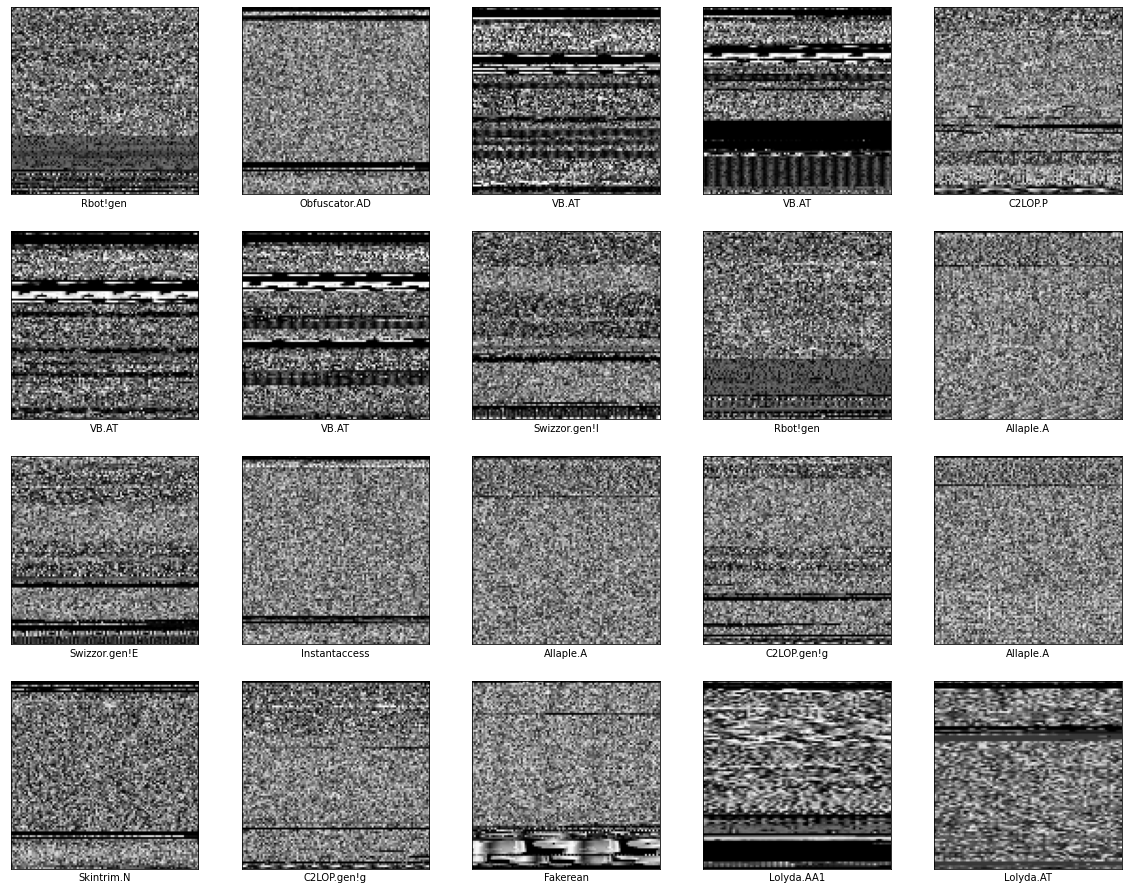

In [11]:
to_show = df.sample(20)

fig_size = (20, 20)
fig = plt.figure(figsize=fig_size)

id = 0
for index, row in to_show.iterrows():
    plt.subplot(5, 5, id + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(row['image'].astype(np.uint8))
    plt.xlabel(row['familyName'])
    id += 1

plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['familyId'], test_size=0.3, random_state=42)

X_train = np.array(list(X_train))
#y_train = np.array(list(y_train))
X_test = np.array(list(X_test))
#y_test = np.array(list(y_test))

# convert numpy arrays to tensors
X_train = tf.convert_to_tensor(X_train)
#y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
#y_test = tf.convert_to_tensor(y_test)

2023-04-30 20:20:01.798169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-04-30 20:20:01.798203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: wmsi
2023-04-30 20:20:01.798213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: wmsi
2023-04-30 20:20:01.798334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-04-30 20:20:01.798359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2023-04-30 20:20:01.798367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.105.17
2023-04-30 20:20:01.804005: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 412320000 exceeds 10% of free system memory.


In [13]:
# Se limita el nivel de log de tensorflow para reducir la carga de procesamiento
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Conv2D

model = Sequential()
'''model.add(Convolution2D(32, (3, 3), strides=(1, 1), input_shape=(DIMENSION, DIMENSION, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))'''

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(DIMENSION, DIMENSION, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


print('input shape', model.input_shape)
print('output shape', model.output_shape)

input shape (None, 100, 100, 3)
output shape (None, 1)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 76832)             0         
                                                                 
 dense (Dense)               (None, 64)                4917312   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,918,273
Trainable params: 4,918,273
Non-trainable params: 0
______________________________________________

In [16]:
model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [17]:
model.fit(X_train, y_train)

108/108 [==============================] - 11s 102ms/step - loss: -125812536.0000 - accuracy: 0.0210


In [18]:
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

47/47 [==============================] - 2s 36ms/step


In [ ]:
y_test

In [ ]:
y_pred

In [ ]:
y_pred_classes

In [ ]:
np.vstack({tuple(row) for row in y_pred_classes})

In [ ]:
y_train

In [ ]:
df.head()

In [ ]:
# PRUEBA ------------------------

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
train_generator = train_datagen.flow_from_dataframe(dataframe=df, 
                                                    x_col='path', 
                                                    y_col='familyName', 
                                                    target_size=(224, 224), 
                                                    batch_size=32, 
                                                    class_mode='categorical', 
                                                    subset='training')
valid_generator = train_datagen.flow_from_dataframe(dataframe=df, 
                                                    x_col='path', 
                                                    y_col='familyName', 
                                                    target_size=(224, 224), 
                                                    batch_size=32, 
                                                    class_mode='categorical', 
                                                    subset='validation')


Found 3437 validated image filenames belonging to 25 classes.
Found 1472 validated image filenames belonging to 25 classes.


In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10


2023-04-30 20:20:28.380214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  1/108 [..............................] - ETA: 36:22 - loss: 5.4112 - accuracy: 0.0625

In [ ]:
loss, accuracy = model.evaluate_generator(valid_generator)
print(f'Validation accuracy: {accuracy}')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=df, 
                                                  x_col='path', 
                                                  target_size=(224, 224), 
                                                  batch_size=32, 
                                                  class_mode=None)
predictions = model.predict_generator(test_generator)